In [1]:
!pip install gdown


In [2]:
!gdown --id 1WFmPIGS5AceGMJRshzciS6jcwN8me4Ke

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1WFmPIGS5AceGMJRshzciS6jcwN8me4Ke
From (redirected): https://drive.google.com/uc?id=1WFmPIGS5AceGMJRshzciS6jcwN8me4Ke&confirm=t&uuid=c4556ccf-4468-4d6f-9870-b27a13f1fb41
To: /content/images.zip
100% 1.40G/1.40G [00:20<00:00, 67.2MB/s]


In [3]:
!gdown --id 1y4R4T7UGJy-TXCJ4nqpHUE8L7j81HgkC

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1y4R4T7UGJy-TXCJ4nqpHUE8L7j81HgkC
To: /content/cytologia-data-1732098640162.csv
100% 1.82M/1.82M [00:00<00:00, 15.7MB/s]


In [4]:
import zipfile
with zipfile.ZipFile('/content/images.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Images')


In [5]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

In [6]:
# Load the data
data_file = "/content/cytologia-data-1732098640162.csv"
image_dir = "/content/Images/dataset_cytologia"
data = pd.read_csv(data_file)

In [7]:
data

NAME   x1   y1   x2   y2 class
0      cf7734a2-b.jpg   99   88  266  276   PNN
1      e6a3b579-0.jpg   92   78  272  284    MO
2      60f95776-f.jpg  110  103  251  251    MM
3      0894e581-c.jpg  112  121  248  262   LyB
4      3998a979-3.jpg   94   86  276  281    MO
...               ...  ...  ...  ...  ...   ...
52743  ddd3c8e9-5.jpg  133  132  226  231    LF
52744  1fa717be-0.jpg  109  112  252  257     M
52745  1e923263-9.jpg  174  177  446  429   MoB
52746  08112a14-8.jpg  122  135  241  248   LyB
52747  9902b9c7-0.jpg  114   26  250  172   PNN

[52748 rows x 6 columns]

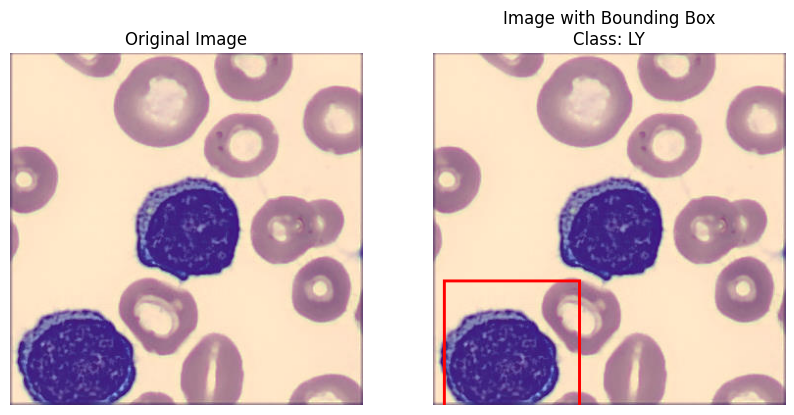

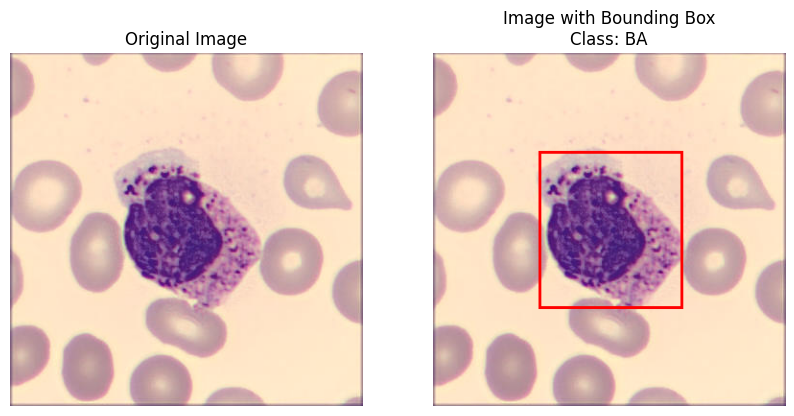

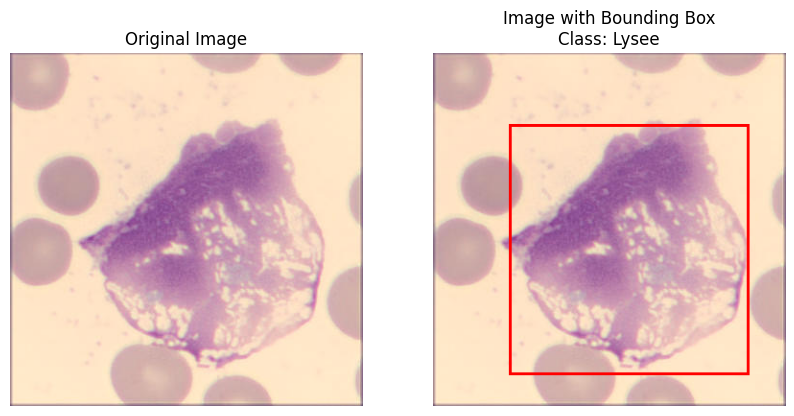

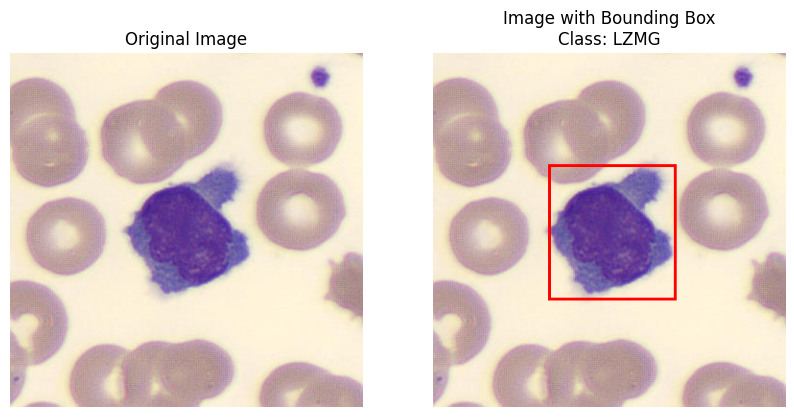

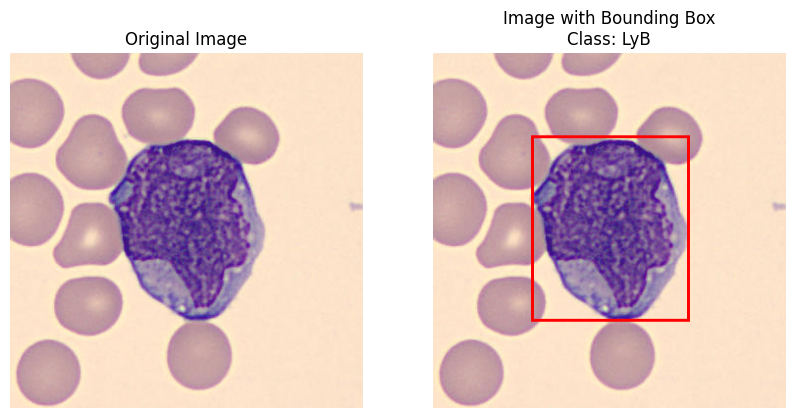

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw



# Function to draw bounding boxes on the image
def draw_bounding_box(image_path, coordinates):
    with Image.open(image_path) as img:
        draw = ImageDraw.Draw(img)
        draw.rectangle(
            [coordinates['x1'], coordinates['y1'], coordinates['x2'], coordinates['y2']],
            outline="red",
            width=3
        )
        return img

num_images_to_visualize = 5 
sample_data = data.sample(num_images_to_visualize)  # Randomly sample rows from the dataset

for index, row in sample_data.iterrows():
    image_path = f"{image_dir}/{row['NAME']}"

    # Original image
    original_img = Image.open(image_path)

    # Image with bounding box
    bbox_coordinates = {
        'x1': row['x1'],
        'y1': row['y1'],
        'x2': row['x2'],
        'y2': row['y2']
    }
    image_with_bbox = draw_bounding_box(image_path, bbox_coordinates)

    # Plot the images
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original_img)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(image_with_bbox)
    axs[1].set_title(f"Image with Bounding Box\nClass: {row['class']}")
    axs[1].axis("off")

    plt.show()


In [9]:

class_mapping = {label: idx for idx, label in enumerate(data['class'].unique())}
data['class_idx'] = data['class'].map(class_mapping)



print("Class Mapping:", class_mapping)
print(data.head())


Class Mapping: {'PNN': 0, 'MO': 1, 'MM': 2, 'LyB': 3, 'LGL': 4, 'Thromb': 5, 'LLC': 6, 'LAM3': 7, 'EO': 8, 'LY': 9, 'BA': 10, 'MoB': 11, 'LM': 12, 'LH_lyAct': 13, 'Lysee': 14, 'Er': 15, 'LF': 16, 'LZMG': 17, 'MBL': 18, 'SS': 19, 'PM': 20, 'B': 21, 'M': 22}
             NAME   x1   y1   x2   y2 class  class_idx
0  cf7734a2-b.jpg   99   88  266  276   PNN          0
1  e6a3b579-0.jpg   92   78  272  284    MO          1
2  60f95776-f.jpg  110  103  251  251    MM          2
3  0894e581-c.jpg  112  121  248  262   LyB          3
4  3998a979-3.jpg   94   86  276  281    MO          1


In [10]:
class_counts = data['class_idx'].value_counts()

print(class_counts)

class_idx
0     6827
14    3408
7     3338
6     3158
3     3029
1     2743
18    2668
4     2439
8     2432
5     2319
15    2308
21    2263
16    2131
9     2092
22    1994
2     1707
13    1705
11    1531
20    1152
10    1001
12     944
17     845
19     714
Name: count, dtype: int64


In [11]:
target_count = 714
balanced_df = data.groupby('class_idx').apply(lambda x: x.sample(n=target_count, random_state=42) if len(x) > target_count else x).reset_index(drop=True)
balanced_counts = balanced_df['class_idx'].value_counts()
print(balanced_counts)

class_idx
0     714
1     714
2     714
3     714
4     714
5     714
6     714
7     714
8     714
9     714
10    714
11    714
12    714
13    714
14    714
15    714
16    714
17    714
18    714
19    714
20    714
21    714
22    714
Name: count, dtype: int64


<ipython-input-11-3adb81137a5b>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = data.groupby('class_idx').apply(lambda x: x.sample(n=target_count, random_state=42) if len(x) > target_count else x).reset_index(drop=True)


In [12]:
balanced_df

NAME   x1   y1   x2   y2 class  class_idx
0      700758c7-7.jpg  121  117  242  255   PNN          0
1      80b955c8-9.jpg  102  100  265  277   PNN          0
2      256c58d8-e.jpg   98   94  271  265   PNN          0
3      52fc7b96-c.jpg  107  104  264  262   PNN          0
4      771235d9-b.jpg   97   96  260  272   PNN          0
...               ...  ...  ...  ...  ...   ...        ...
16417  8625d521-1.jpg  109  103  245  261     M         22
16418  61da8153-1.jpg   63  100  235  274     M         22
16419  e0ec7a12-b.jpg  103   83  260  247     M         22
16420  efba3d60-3.jpg  102  114  254  251     M         22
16421  d152fdfc-e.jpg  111  115  250  253     M         22

[16422 rows x 7 columns]

In [13]:
balanced_df = balanced_df.drop(columns=['class'])

In [14]:
balanced_df

NAME   x1   y1   x2   y2  class_idx
0      700758c7-7.jpg  121  117  242  255          0
1      80b955c8-9.jpg  102  100  265  277          0
2      256c58d8-e.jpg   98   94  271  265          0
3      52fc7b96-c.jpg  107  104  264  262          0
4      771235d9-b.jpg   97   96  260  272          0
...               ...  ...  ...  ...  ...        ...
16417  8625d521-1.jpg  109  103  245  261         22
16418  61da8153-1.jpg   63  100  235  274         22
16419  e0ec7a12-b.jpg  103   83  260  247         22
16420  efba3d60-3.jpg  102  114  254  251         22
16421  d152fdfc-e.jpg  111  115  250  253         22

[16422 rows x 6 columns]

In [15]:
print("\nMissing values in each column:")
print(balanced_df.isnull().sum())


Missing values in each column:
NAME         0
x1           0
y1           0
x2           0
y2           0
class_idx    0
dtype: int64


In [16]:
print("\nClass distribution:")
class_distribution = balanced_df['class_idx'].value_counts()
print(class_distribution)


Class distribution:
class_idx
0     714
1     714
2     714
3     714
4     714
5     714
6     714
7     714
8     714
9     714
10    714
11    714
12    714
13    714
14    714
15    714
16    714
17    714
18    714
19    714
20    714
21    714
22    714
Name: count, dtype: int64


In [17]:
# Check for invalid bounding boxes
invalid_boxes = balanced_df[
    (balanced_df['x1'] >= balanced_df['x2']) |
    (balanced_df['y1'] >= balanced_df['y2'])
]
print("Invalid bounding boxes:")
print(invalid_boxes)

# Drop invalid rows
balanced_df = balanced_df.drop(invalid_boxes.index)
print(f"\nDataset after removing invalid boxes: {balanced_df.shape[0]} samples")


Invalid bounding boxes:
Empty DataFrame
Columns: [NAME, x1, y1, x2, y2, class_idx]
Index: []

Dataset after removing invalid boxes: 16422 samples


In [18]:
# Check for duplicate rows
duplicates = balanced_df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

# Drop duplicates if any
balanced_df = balanced_df.drop_duplicates()


Number of duplicate rows: 0


In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset
train_df, test_df = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df['class_idx'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, stratify=train_df['class_idx'], random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Testing samples: {len(test_df)}")


Training samples: 9852
Validation samples: 3285
Testing samples: 3285


In [ ]:
balanced_df

NAME   x1   y1   x2   y2  class_idx
0      700758c7-7.jpg  121  117  242  255          0
1      80b955c8-9.jpg  102  100  265  277          0
2      256c58d8-e.jpg   98   94  271  265          0
3      52fc7b96-c.jpg  107  104  264  262          0
4      771235d9-b.jpg   97   96  260  272          0
...               ...  ...  ...  ...  ...        ...
16417  8625d521-1.jpg  109  103  245  261         22
16418  61da8153-1.jpg   63  100  235  274         22
16419  e0ec7a12-b.jpg  103   83  260  247         22
16420  efba3d60-3.jpg  102  114  254  251         22
16421  d152fdfc-e.jpg  111  115  250  253         22

[16422 rows x 6 columns]

In [19]:
import os
import cv2
import numpy as np
import pandas as pd
image_dir = "/content/Images/dataset_cytologia"  
mask_dir = "/content/Images/masks"  
os.makedirs(mask_dir, exist_ok=True)

# Function to generate masks
def create_masks(df, image_dir, mask_dir):
    for _, row in df.iterrows():
        image_path = os.path.join(image_dir, row['NAME'])
        image = cv2.imread(image_path)
        if image is None:
            print(f"Image not found: {image_path}")
            continue  # Skip missing images

        # Get image dimensions
        height, width, _ = image.shape

        # Create a blank mask
        mask = np.zeros((height, width), dtype=np.uint8)

        # Get bounding box coordinates
        x1, y1, x2, y2 = int(row['x1']), int(row['y1']), int(row['x2']), int(row['y2'])

        # Draw the bounding box on the mask
        cv2.rectangle(mask, (x1, y1), (x2, y2), color=1, thickness=-1)  # Fill the box with 1

        # Save the mask
        mask_filename = row['NAME'].replace('.jpg', '_mask.png')
        mask_path = os.path.join(mask_dir, mask_filename)
        cv2.imwrite(mask_path, mask)

# Generate masks
create_masks(balanced_df, image_dir, mask_dir)
print(f"Masks saved to: {mask_dir}")

Masks saved to: /content/Images/masks


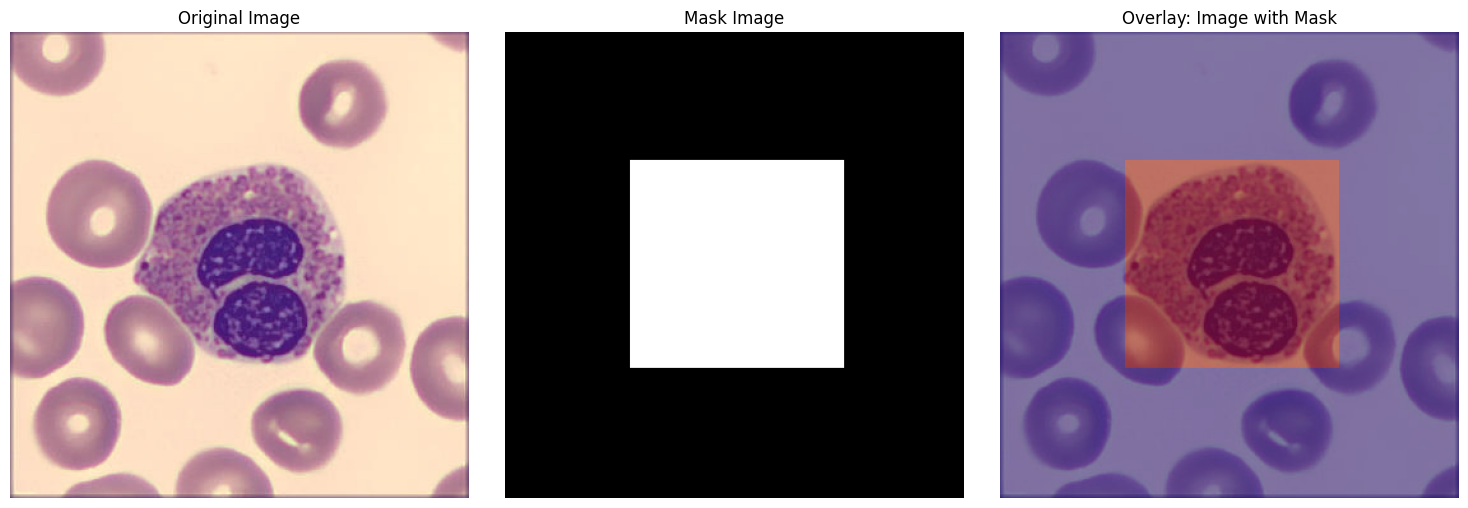

In [22]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Directories
image_dir = "/content/Images/dataset_cytologia"
mask_dir = "/content/Images/masks"

# Get a list of mask filenames (we assume masks end with '_mask.png')
mask_files = [f for f in os.listdir(mask_dir) if f.endswith('_mask.png')]

if not mask_files:
    raise ValueError("No mask files found in the directory.")

mask_file = mask_files[0]
mask_path = os.path.join(mask_dir, mask_file)

# Derive the corresponding image filename by replacing '_mask.png' with '.jpg'
image_file = mask_file.replace('_mask.png', '.jpg')
image_path = os.path.join(image_dir, image_file)

# Read the original image and the mask
image = cv2.imread(image_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

if image is None:
    raise FileNotFoundError(f"Original image not found: {image_path}")
if mask is None:
    raise FileNotFoundError(f"Mask not found: {mask_path}")

# Convert image from BGR to RGB for proper display in Matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Option 1: Display the mask as a separate image
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask Image")
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(image_rgb)
plt.imshow(mask, cmap='jet', alpha=0.5)  
plt.title("Overlay: Image with Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


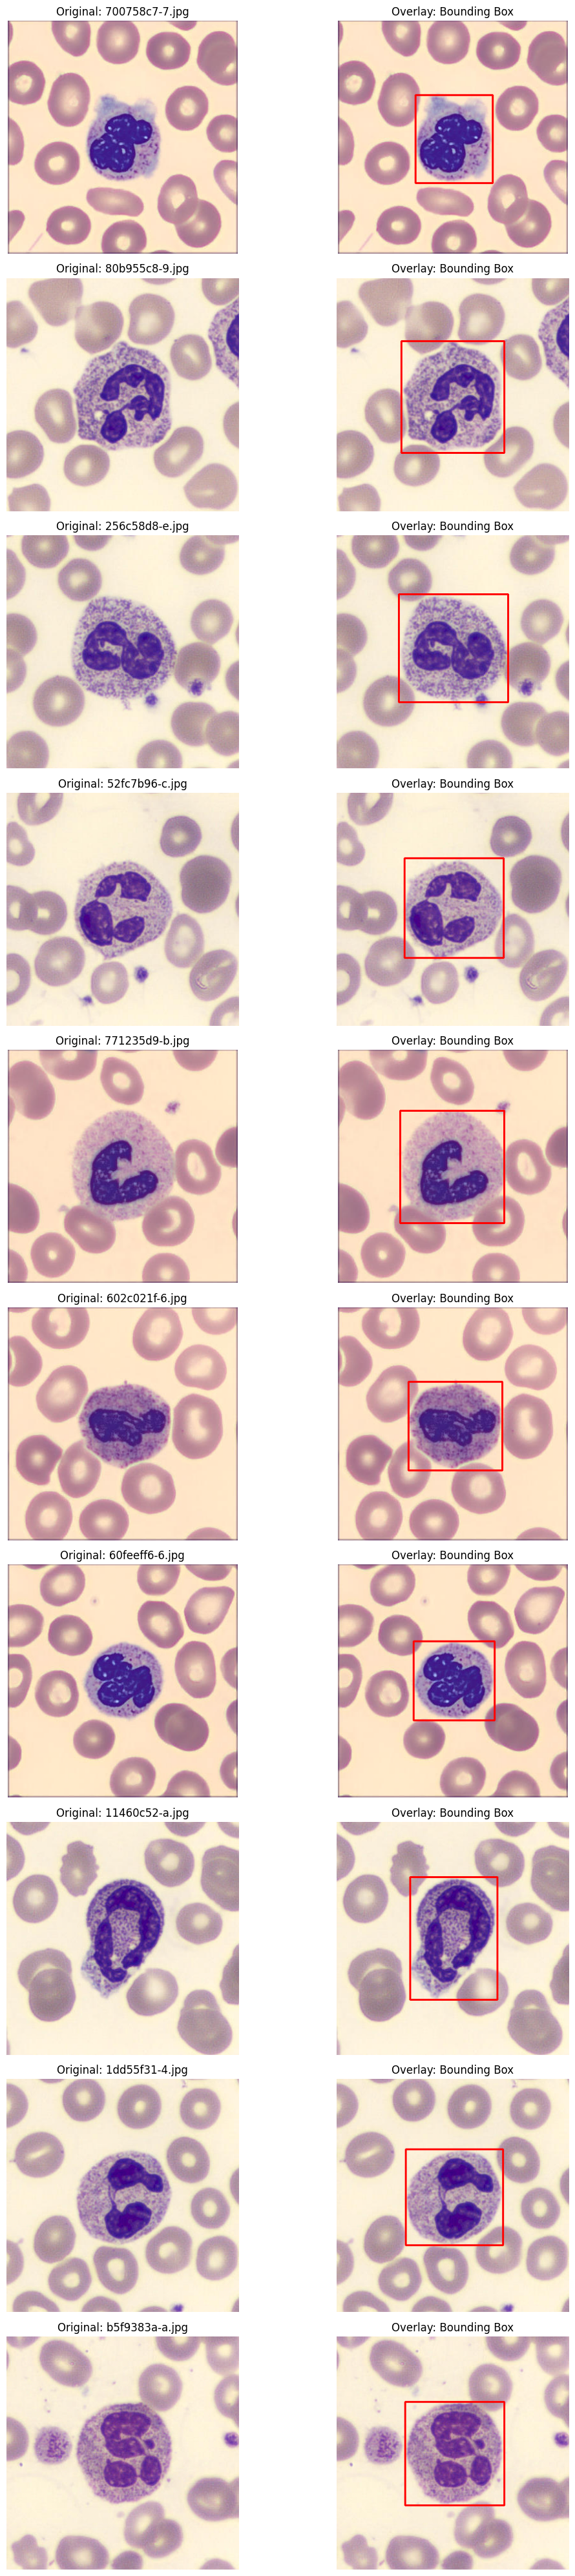

In [23]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Directories
image_dir = "/content/Images/dataset_cytologia"

num_test_images = 10


fig, axes = plt.subplots(num_test_images, 2, figsize=(12, num_test_images * 4))

# Loop through the first 10 rows of the dataframe.
for idx, (_, row) in enumerate(balanced_df.head(num_test_images).iterrows()):
    image_filename = row['NAME']
    image_path = os.path.join(image_dir, image_filename)

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image not found: {image_path}")
        continue

    # Convert the image from BGR to RGB for Matplotlib.
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Copy the original to create the overlay image.
    overlay_image = image_rgb.copy()

    # Get bounding box coordinates (ensure they are integers)
    x1, y1, x2, y2 = int(row['x1']), int(row['y1']), int(row['x2']), int(row['y2'])

    # Draw the bounding box on the overlay image.
    # Here we set the color to red (R, G, B) and thickness to 2.
    cv2.rectangle(overlay_image, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)

    # Plot the original image
    ax_orig = axes[idx, 0] if num_test_images > 1 else axes[0]
    ax_orig.imshow(image_rgb)
    ax_orig.set_title(f"Original: {image_filename}")
    ax_orig.axis("off")

    # Plot the overlay image
    ax_overlay = axes[idx, 1] if num_test_images > 1 else axes[1]
    ax_overlay.imshow(overlay_image)
    ax_overlay.set_title("Overlay: Bounding Box")
    ax_overlay.axis("off")

plt.tight_layout()
plt.show()



Masks saved in /content/Images/saved_masks


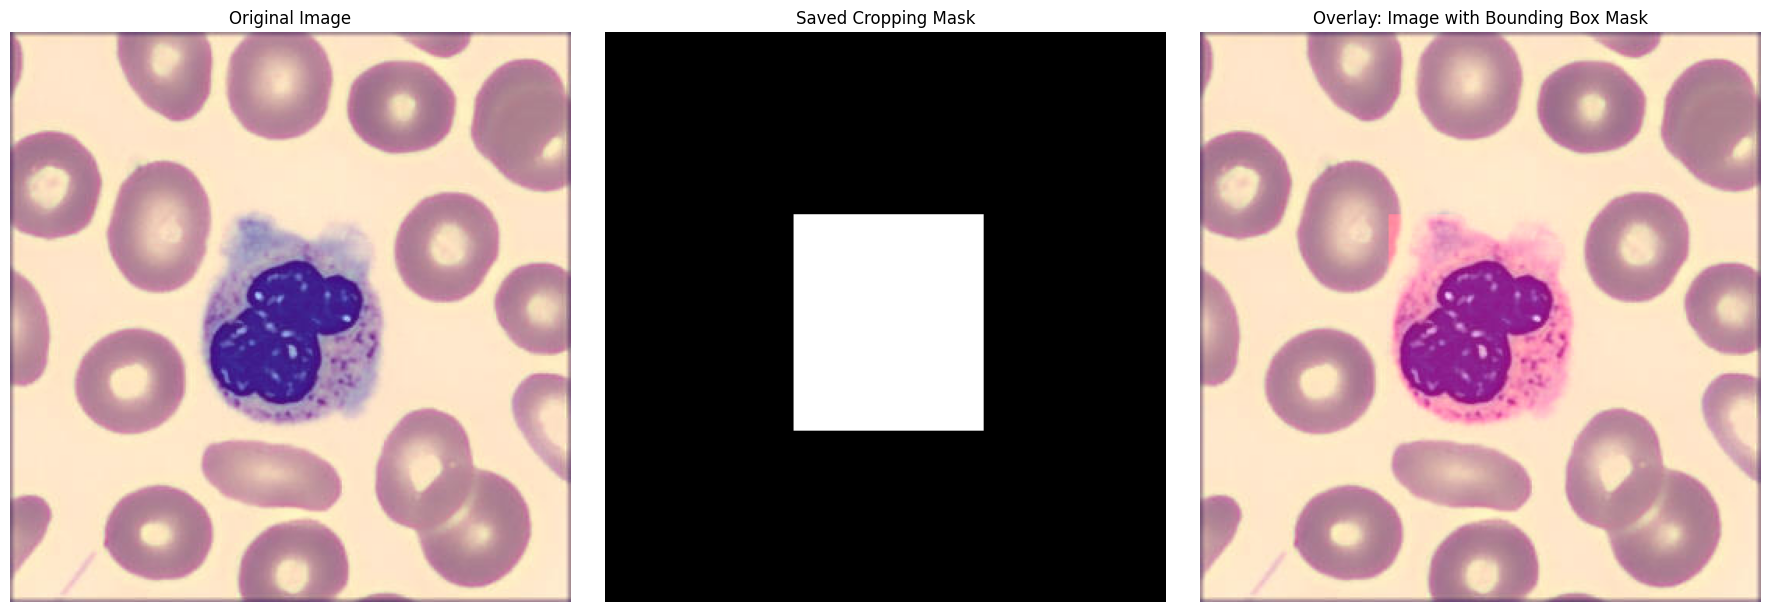

In [24]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Directories
image_dir = "/content/Images/dataset_cytologia"  
mask_dir = "/content/Images/saved_masks"        
os.makedirs(mask_dir, exist_ok=True)

for idx, row in balanced_df.iterrows():
    image_filename = row['NAME']
    image_path = os.path.join(image_dir, image_filename)

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image not found: {image_path}")
        continue

    # Get dimensions of the image
    height, width, _ = image.shape


    mask = np.zeros((height, width), dtype=np.uint8)

    # Get bounding box coordinates and ensure they are integers
    x1, y1, x2, y2 = int(row['x1']), int(row['y1']), int(row['x2']), int(row['y2'])

    # Draw the bounding box (filled rectangle) on the mask with value 1
    cv2.rectangle(mask, (x1, y1), (x2, y2), color=1, thickness=-1)

    mask_to_save = (mask * 255).astype(np.uint8)
    mask_filename = image_filename.replace('.jpg', '_mask.png')  
    mask_path = os.path.join(mask_dir, mask_filename)
    cv2.imwrite(mask_path, mask_to_save)

print(f"Masks saved in {mask_dir}")

# ----- Visualization for One Example -----
sample_row = balanced_df.iloc[0]
image_filename = sample_row['NAME']
image_path = os.path.join(image_dir, image_filename)
mask_filename = image_filename.replace('.jpg', '_mask.png')
mask_path = os.path.join(mask_dir, mask_filename)

# Load the original image and its saved mask
image = cv2.imread(image_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Convert image from BGR to RGB for display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width, _ = image_rgb.shape

# Create a color version of the mask (here we use red to highlight the bounding box region)
mask_color = np.zeros_like(image_rgb)
mask_color[:, :, 0] = mask  #

# Create an overlay image using alpha blending
alpha = 0.3
overlay_image = cv2.addWeighted(image_rgb, 1.0, mask_color, alpha, 0)

# Plot the original image, the mask, and the overlay
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original Image
axes[0].imshow(image_rgb)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Binary Mask
axes[1].imshow(mask, cmap='gray')
axes[1].set_title("Saved Cropping Mask")
axes[1].axis('off')

# Overlay (image with bounding box)
axes[2].imshow(overlay_image)
axes[2].set_title("Overlay: Image with Bounding Box Mask")
axes[2].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Directories
image_dir = "/content/Images/dataset_cytologia" 
mask_dir = "/content/Images/saved_masks"        
os.makedirs(mask_dir, exist_ok=True)

# ---------------------------
# 1. Create and Save Masks
# ---------------------------
for idx, row in balanced_df.iterrows():
    image_filename = row['NAME']
    image_path = os.path.join(image_dir, image_filename)

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image not found: {image_path}")
        continue

    # Get dimensions of the image
    height, width, _ = image.shape

    # Create an empty mask of the same size (binary mask: 0 for background, 1 for bounding box region)
    mask = np.zeros((height, width), dtype=np.uint8)

    # Get bounding box coordinates and ensure they are integers and within image boundaries
    x1, y1, x2, y2 = (
        max(0, int(row['x1'])),
        max(0, int(row['y1'])),
        min(width, int(row['x2'])),
        min(height, int(row['y2']))
    )

    # Draw the bounding box (filled rectangle) on the mask with value 1
    cv2.rectangle(mask, (x1, y1), (x2, y2), color=1, thickness=-1)

    # Save the mask image (scale values to 0 and 255 for display)
    mask_to_save = (mask * 255).astype(np.uint8)
    mask_filename = image_filename.replace('.jpg', '_mask.png')
    mask_path = os.path.join(mask_dir, mask_filename)
    cv2.imwrite(mask_path, mask_to_save)

print(f"Masks saved in {mask_dir}")

# ---------------------------------------
# 2. Visualize 200 Images with 3 Views per Sample
# ---------------------------------------
# Number of images to visualize
num_images = 200
data_subset = balanced_df.head(num_images)

# For each sample, we want to show 3 images (Original, Mask, Overlay).
# Set up a grid with num_images rows and 3 columns.
fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 2), squeeze=False)

# Loop through each sample in the subset.
for i, (_, row) in enumerate(data_subset.iterrows()):
    # File names for image and corresponding mask.
    image_filename = row['NAME']
    image_path = os.path.join(image_dir, image_filename)
    mask_filename = image_filename.replace('.jpg', '_mask.png')
    mask_path = os.path.join(mask_dir, mask_filename)

    # Load original image and its saved mask.
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Check if image and mask are loaded correctly.
    if image is None or mask is None:
        print(f"Skipping {image_filename} because of loading issue.")
        continue

    # Convert image from BGR to RGB for display.
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Ensure mask dimensions match image dimensions
    if mask.shape[:2] != image_rgb.shape[:2]:
        mask = cv2.resize(mask, (image_rgb.shape[1], image_rgb.shape[0]))

    # 1. Show Original Image.
    axes[i, 0].imshow(image_rgb)
    axes[i, 0].set_title("Original", fontsize=8)
    axes[i, 0].axis("off")

    # 2. Show Mask as Grayscale.
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title("Mask", fontsize=8)
    axes[i, 1].axis("off")

    # 3. Create an Overlay Image.
    # Create a colored mask, here we use the red channel.
    mask_color = np.zeros_like(image_rgb)
    mask_color[:, :, 0] = mask  # red channel; mask is in 0/255 scale
    alpha = 0.3  # Transparency factor.
    overlay_image = cv2.addWeighted(image_rgb, 1.0, mask_color, alpha, 0)

    # Show the Overlay.
    axes[i, 2].imshow(overlay_image)
    axes[i, 2].set_title("Overlay", fontsize=8)
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()


Matched image-mask pairs found: 15836
Train samples:      11085
Validation samples: 2375
Test samples:       2376


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 256)    │        590,080 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 128)    │        131,200 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 256)    │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

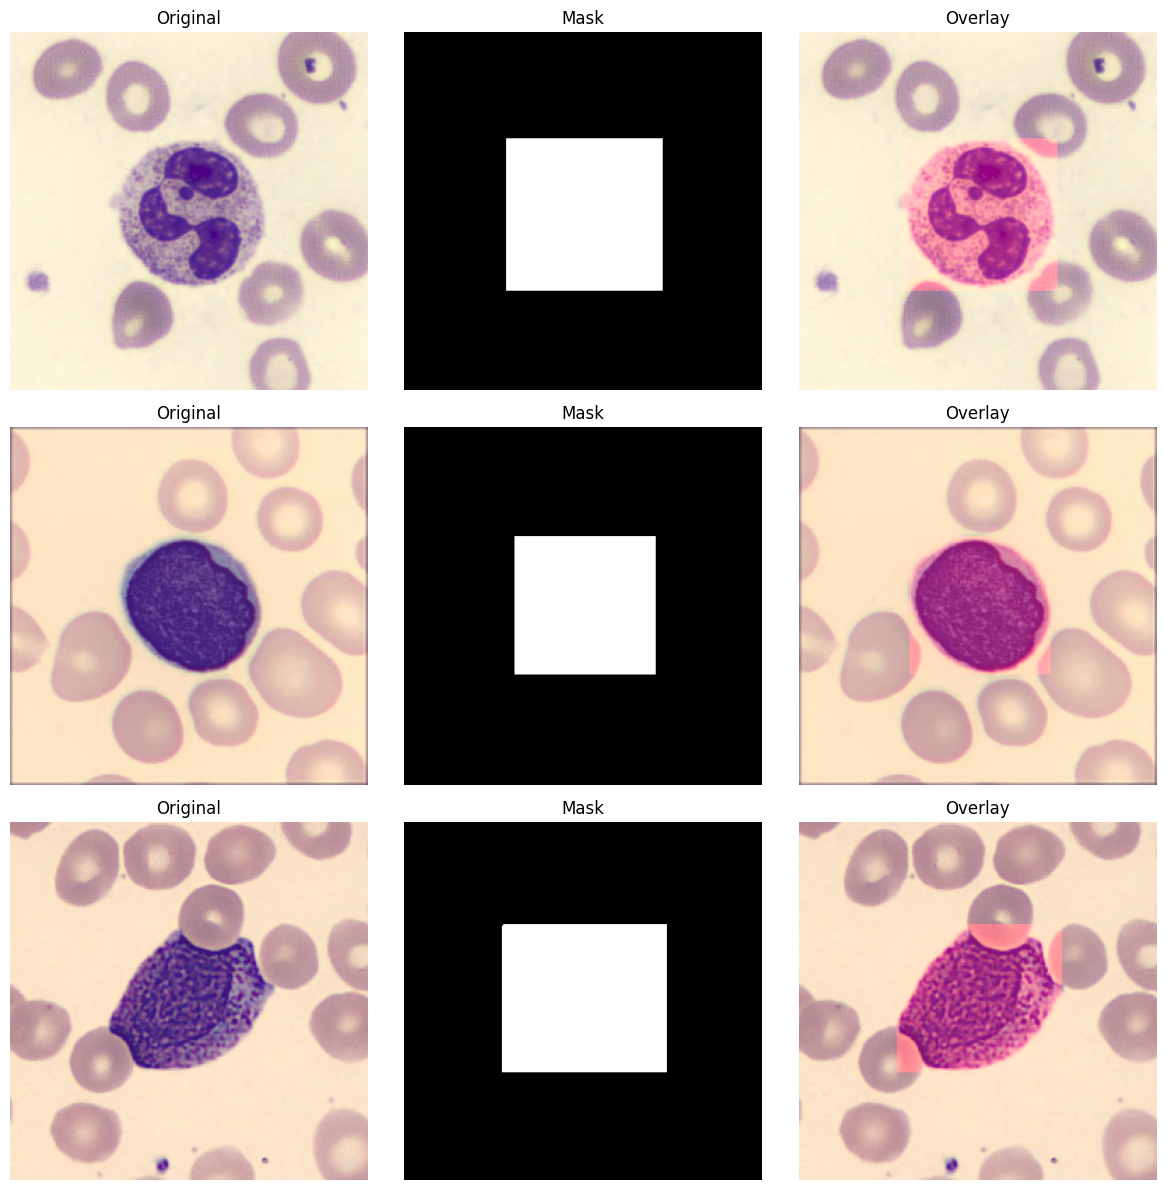

Epoch 1/20
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 144s 45ms/step - f1_score_metric: 0.7039 - loss: 0.1876 - miou: 0.4439 - val_f1_score_metric: 0.8991 - val_loss: 0.0844 - val_miou: 0.7723
Epoch 2/20
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 117s 40ms/step - f1_score_metric: 0.9029 - loss: 0.0831 - miou: 0.6360 - val_f1_score_metric: 0.8980 - val_loss: 0.0840 - val_miou: 0.7624
Epoch 3/20
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 145s 42ms/step - f1_score_metric: 0.9137 - loss: 0.0707 - miou: 0.6618 - val_f1_score_metric: 0.9152 - val_loss: 0.0665 - val_miou: 0.8026
Epoch 4/20
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 117s 42ms/step - f1_score_metric: 0.9160 - loss: 0.0666 - miou: 0.6706 - val_f1_score_metric: 0.8989 - val_loss: 0.0779 - val_miou: 0.7759
Epoch 5/20
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 142s 42ms/step - f1_score_metric: 0.9202 - loss: 0.0634 - miou: 0.6797 - val_f1_score_metric: 0.9136 - val_loss: 0.0670 - val_miou: 0.8034
Epoch 6/20
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 139s 41ms/step - f1_score_metric: 0.9214 - loss: 0.06

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from sklearn.model_selection import train_test_split

# ============================================
# 1. Match Image-Mask Pairs
# ============================================
image_dir = "/content/Images/dataset_cytologia"   # Folder with original images
mask_dir  = "/content/Images/saved_masks"          # Folder with corresponding masks

# List all image files
all_image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
# Create a set of available mask filenames for fast lookup
available_masks = set(os.listdir(mask_dir))

# Filter images that have a corresponding mask.
image_files = []
mask_files = []
for img in all_image_files:
    mask_name = img.replace('.jpg', '_mask.png')  
    if mask_name in available_masks:
        image_files.append(os.path.join(image_dir, img))
        mask_files.append(os.path.join(mask_dir, mask_name))

print("Matched image-mask pairs found:", len(image_files))

# ============================================
# 2. Define Parameters
# ============================================
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 256, 256, 3
BATCH_SIZE = 4  # Try reducing to 2 if needed
AUTOTUNE = tf.data.experimental.AUTOTUNE

# ============================================
# 3. Create a tf.data Pipeline
# ============================================
def parse_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=IMG_CHANNELS)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = tf.cast(image, tf.float32) / 255.0

    # Read & decode mask (as grayscale)
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])
    # Normalize and threshold the mask (assumed to be 0 and 255)
    mask = tf.cast(mask, tf.float32) / 255.0
    mask = tf.where(mask > 0.5, 1.0, 0.0)
    return image, mask

# ============================================
# 4. Split Data: Train (70%) / Validation (15%) / Test (15%)
# ============================================
# First, split out training (70%) and temporary (30%)
img_train, img_temp, mask_train, mask_temp = train_test_split(
    image_files, mask_files, test_size=0.30, random_state=42
)
# Then split the temporary set equally into validation and test (15% each)
img_val, img_test, mask_val, mask_test = train_test_split(
    img_temp, mask_temp, test_size=0.5, random_state=42
)

print("Train samples:     ", len(img_train))
print("Validation samples:", len(img_val))
print("Test samples:      ", len(img_test))

# ============================================
# 5. Create tf.data.Dataset objects
# ============================================
def get_dataset(img_paths, mask_paths, batch_size=BATCH_SIZE, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    dataset = dataset.map(parse_image, num_parallel_calls=AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=100, seed=42)
    dataset = dataset.batch(batch_size)

    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

train_dataset = get_dataset(img_train, mask_train, batch_size=BATCH_SIZE, shuffle=True)
val_dataset   = get_dataset(img_val, mask_val, batch_size=BATCH_SIZE)
test_dataset  = get_dataset(img_test, mask_test, batch_size=BATCH_SIZE)

# ============================================
# 6. Define the U-Net Model Architecture
# ============================================
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    c4 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c9)
    return models.Model(inputs=inputs, outputs=outputs)

model = unet_model()
model.summary()

# ============================================
# 7. Define Custom Metrics: F1 Score and mIoU
# ============================================
def f1_score_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    tp = K.sum(y_true * y_pred)
    precision = tp / (K.sum(y_pred) + K.epsilon())
    recall = tp / (K.sum(y_true) + K.epsilon())
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

class MeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes=2, name="miou", **kwargs):
        super().__init__(num_classes=num_classes, name=name, **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, tf.int32)
        y_true = tf.cast(y_true, tf.int32)
        return super().update_state(y_true, y_pred, sample_weight)

# ============================================
# 8. Compile the Model
# ============================================
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[f1_score_metric, MeanIoU(num_classes=2)])

# ============================================
# 9. Visualize 3 Samples from Training Data (Before Training)
# ============================================
def visualize_samples(dataset, num_samples=3):
    for images, masks in dataset.take(1):
        images = images.numpy()
        masks  = masks.numpy()
    plt.figure(figsize=(12, num_samples * 4))
    for i in range(num_samples):
        img = images[i]
        mask_disp = (masks[i][:, :, 0] * 255).astype(np.uint8)
        img_disp = (img * 255).astype(np.uint8)
        mask_color = np.zeros_like(img_disp)
        mask_color[..., 0] = mask_disp
        overlay = cv2.addWeighted(img_disp, 1.0, mask_color, 0.3, 0)

        plt.subplot(num_samples, 3, i*3+1)
        plt.imshow(img)
        plt.title("Original")
        plt.axis("off")

        plt.subplot(num_samples, 3, i*3+2)
        plt.imshow(mask_disp, cmap='gray')
        plt.title("Mask")
        plt.axis("off")

        plt.subplot(num_samples, 3, i*3+3)
        plt.imshow(overlay)
        plt.title("Overlay")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_samples(train_dataset, num_samples=3)

# ============================================
# 10. Train the Model (Verbose = 1)
# ============================================
EPOCHS = 20

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1
)

print("Training history keys:", history.history.keys())

# ============================================
# 11. Evaluate the Model on the Test Set and Print the Results
# ============================================
test_loss, test_f1, test_miou = model.evaluate(test_dataset, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test mIoU: {test_miou:.4f}")

# ============================================
# 12. Visualize Predictions on 20 Test Images
# ============================================
def predict_and_visualize(model, dataset, num_samples=20):
    imgs = []
    masks_true = []
    for images, masks in dataset:
        imgs.append(images)
        masks_true.append(masks)
        if sum(item.shape[0] for item in imgs) >= num_samples:
            break
    imgs = tf.concat(imgs, axis=0)[:num_samples]
    masks_true = tf.concat(masks_true, axis=0)[:num_samples]

    imgs_np = imgs.numpy()
    masks_true_np = masks_true.numpy()

    fig, axes = plt.subplots(num_samples, 4, figsize=(20, num_samples*4))
    for i in range(num_samples):
        img = imgs_np[i]
        gt_mask = masks_true_np[i][:, :, 0]
        pred_mask = model.predict(np.expand_dims(img, axis=0))[0]
        pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)[:, :, 0]

        img_disp = (img*255).astype(np.uint8)
        mask_color = np.zeros_like(img_disp)
        mask_color[:,:,0] = (pred_mask_bin*255).astype(np.uint8)
        overlay = cv2.addWeighted(img_disp, 1.0, mask_color, 0.3, 0)

        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Original")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(gt_mask, cmap='gray')
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(pred_mask_bin, cmap='gray')
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title("Overlay")
        axes[i, 3].axis("off")

    plt.tight_layout()
    plt.show()

predict_and_visualize(model, test_dataset, num_samples=20)


In [2]:
model

<Functional name=functional, built=True>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


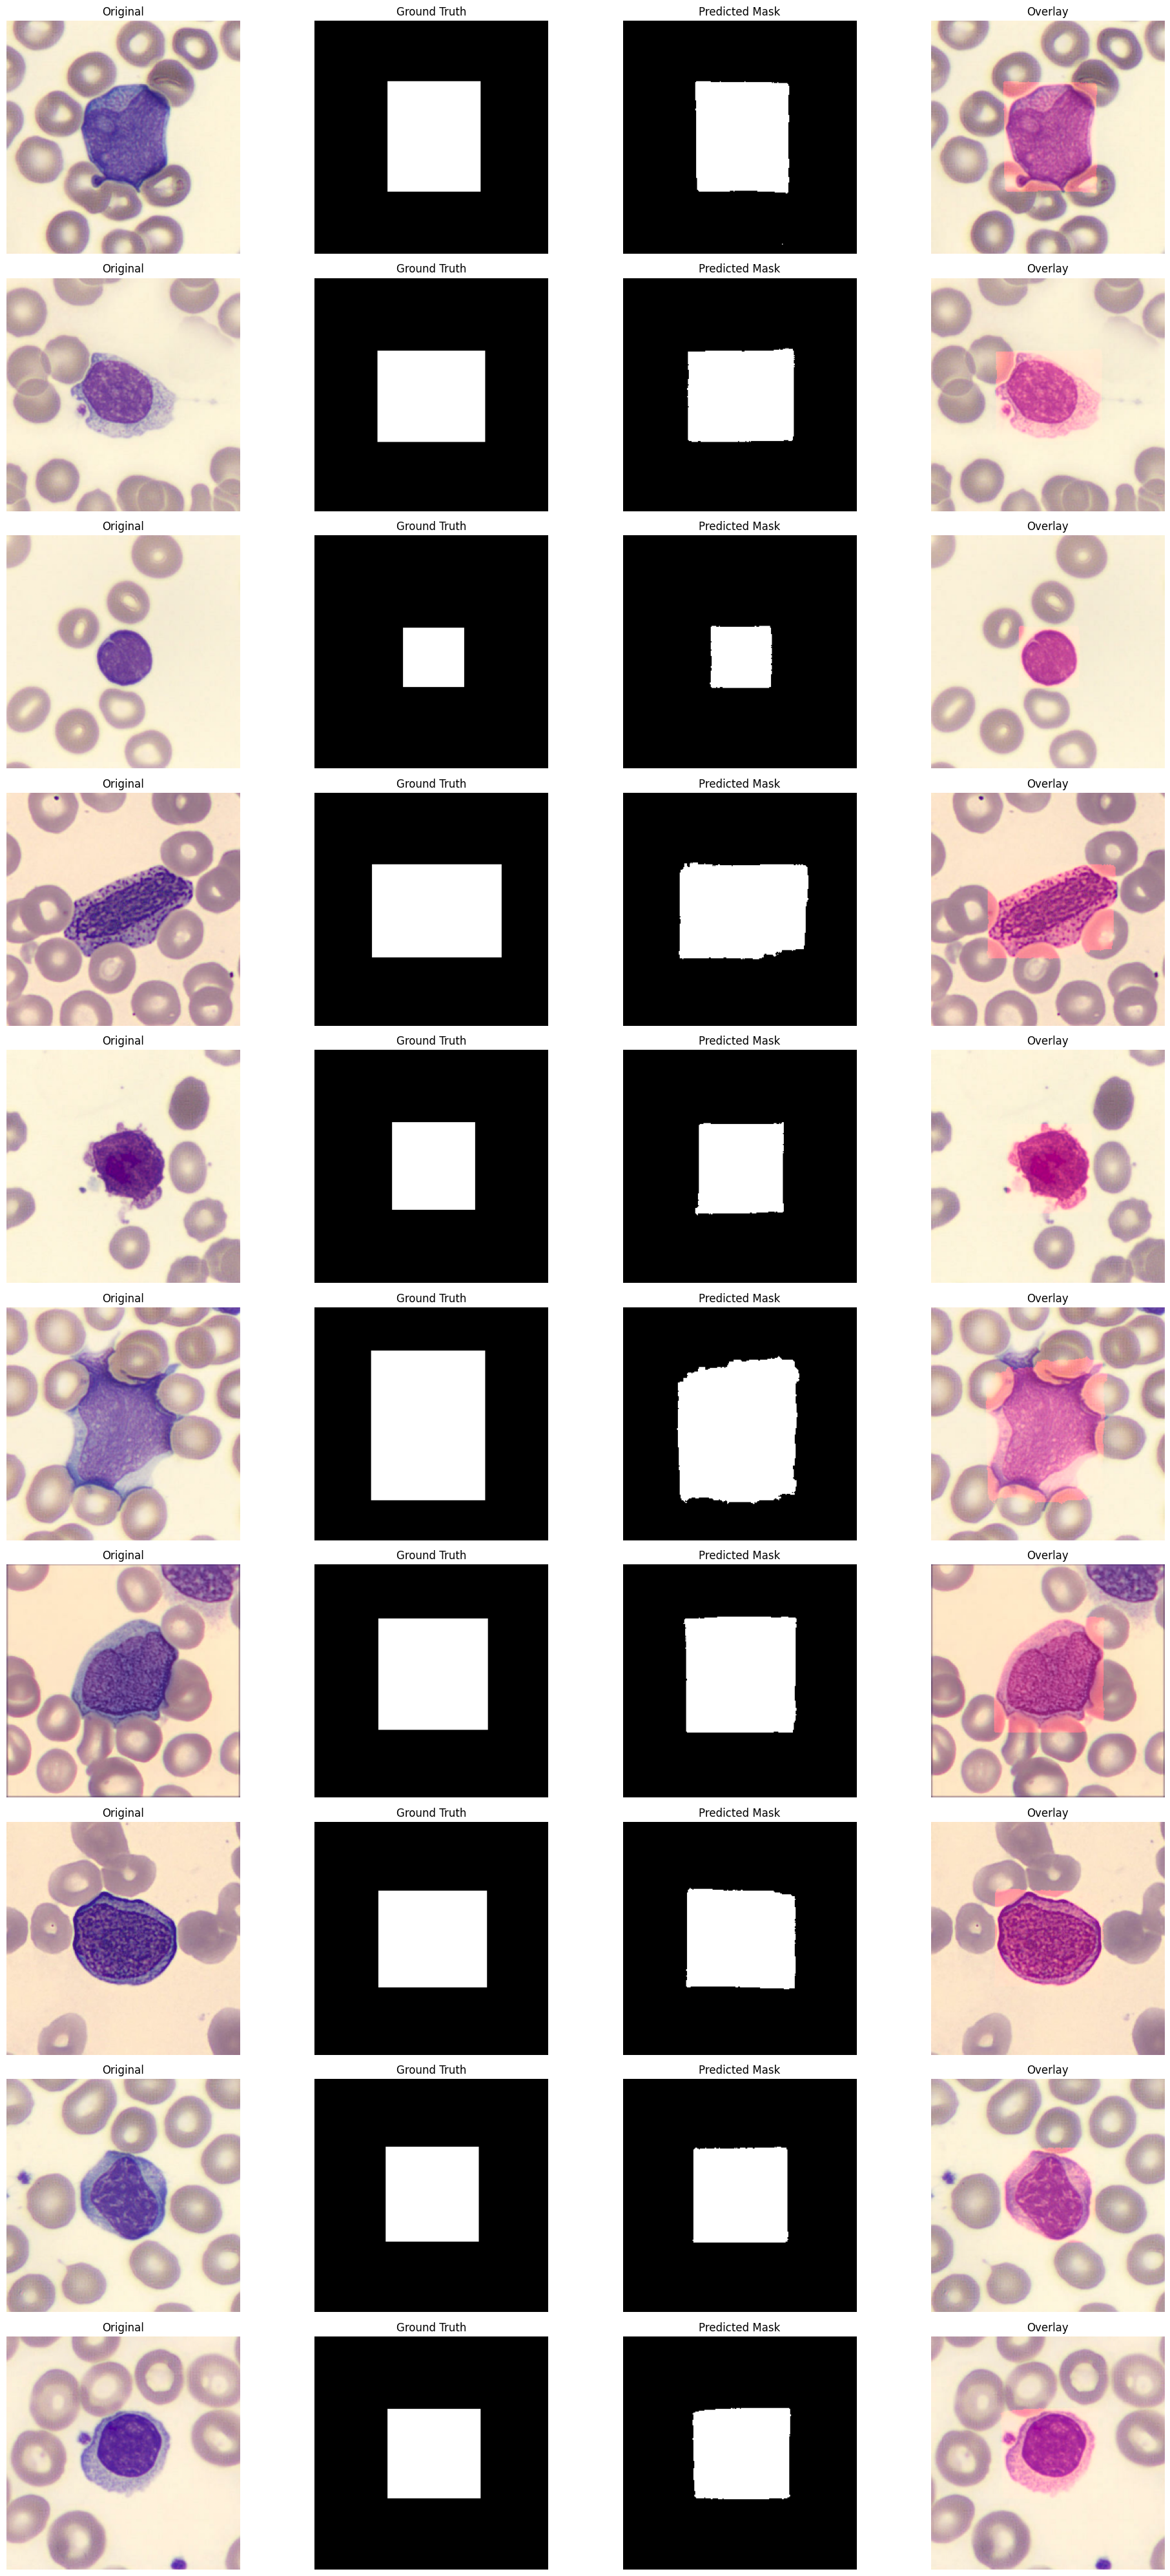

In [4]:
predict_and_visualize(model, test_dataset, num_samples=10)


test visualize 100 image

In [ ]:
predict_and_visualize(model, test_dataset, num_samples=100)


In [5]:
!pip install huggingface_hub

from huggingface_hub import notebook_login
notebook_login()  

In [7]:
MODEL_DIR = "unet_model.keras"
model.save(MODEL_DIR)


In [16]:
from huggingface_hub import create_repo

repo_id = "fasfxczxz/project_machiene" 
create_repo(repo_id, exist_ok=True)


RepoUrl('https://huggingface.co/fasfxczxz/project_machiene', endpoint='https://huggingface.co', repo_type='model', repo_id='fasfxczxz/project_machiene')

In [17]:
from huggingface_hub import HfApi
import os

api = HfApi()
model_path = "unet_model.keras" 

if os.path.isdir(model_path):
    # Upload all files from the directory
    for root, _, files in os.walk(model_path):
        for file in files:
            file_path = os.path.join(root, file)
            repo_path = os.path.relpath(file_path, start=model_path)
            print(f"Uploading {file_path} as {repo_path} ...")
            api.upload_file(
                path_or_fileobj=file_path,
                path_in_repo=repo_path,
                repo_id=repo_id,
                repo_type="model"
            )
else:
    api.upload_file(
        path_or_fileobj=model_path,
        path_in_repo=model_path,
        repo_id=repo_id,
        repo_type="model"
    )


unet_model.keras:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

In [14]:
from huggingface_hub import HfApi, Repository

repo_id = "fasfxczxz/project_machiene"  
model_path = "unet_model.keras"  

import os

api = HfApi()

for root, _, files in os.walk(model_path):
    for file in files:
        file_path = os.path.join(root, file)
        # We create a relative path to store in the repository
        repo_path = os.path.relpath(file_path, start=model_path)
        print(f"Uploading {file_path} as {repo_path} ...")
        api.upload_file(
            path_or_fileobj=file_path,
            path_in_repo=repo_path,
            repo_id=repo_id,
            repo_type="model"  
        )


In [9]:
from huggingface_hub import Repository, create_repo
import shutil
import os

repo_name = "project_machiene"        
username = "fasfxczxz"                
repo_id = f"{username}/{repo_name}"   

try:
    create_repo(repo_id=repo_id, exist_ok=True, private=False)
    print(f"Repository '{repo_id}' is ready.")
except Exception as e:
    print("Error creating repository:", e)

local_dir = "model_repo"
if not os.path.exists(local_dir):
    repo = Repository(local_dir=local_dir, clone_from=repo_id)
else:
    repo = Repository(local_dir=local_dir)


Repository 'fasfxczxz/project_machiene' is ready.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
